# Fully Convolutional Networks for Semantic Segmentation

Run in the docker image found in https://github.com/waspinator/deep-learning-explorer


In [1]:
import os
import sys
import zipfile
import random
import math
import re
import time
import numpy as np
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt

sys.path.insert(0, '../libraries')
import semantic.coco
import semantic.config
import semantic.weights
import semantic.fcn
import semantic.evaluate
import semantic.utils

%matplotlib inline
%config IPCompleter.greedy=True

HOME_DIR = '/home/keras'
ROOT_DATA_DIR = os.path.join(HOME_DIR, "data")
WEIGHTS_DIR = os.path.join(HOME_DIR, "data/weights")

Using TensorFlow backend.


# Dataset

Your data should be in the [COCO style format](http://cocodataset.org/#download).

Organize the dataset using the following structure:

```
DATA_DIR
│
└───annotations
│   │   instances_<subset><year>.json
│   
└───<subset><year>
    │   image021.jpeg
    │   image022.jpeg
```

In [2]:
with zipfile.ZipFile(os.path.join(ROOT_DATA_DIR, "shapes.zip"), "r") as zip_ref:
    zip_ref.extractall(ROOT_DATA_DIR)

DATA_DIR = os.path.join(ROOT_DATA_DIR, "shapes")
MODEL_DIR = os.path.join(DATA_DIR, "logs")

In [3]:
dataset_train = semantic.coco.CocoDataset()
dataset_train.load_coco(DATA_DIR, subset="shapes_train", year="2018")
dataset_train.prepare()

dataset_validate = semantic.coco.CocoDataset()
dataset_validate.load_coco(DATA_DIR, subset="shapes_validate", year="2018")
dataset_validate.prepare()

dataset_test = semantic.coco.CocoDataset()
dataset_test.load_coco(DATA_DIR, subset="shapes_test", year="2018")
dataset_test.prepare()

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


# Configuration

In [4]:
class ShapesFcnConfig(semantic.config.Config):
    """Configuration for training on the Shapes dataset.
    Derives from the base Config class and overrides values specific
    to the Shapes dataset.
    """
    NAME = "shapes_fcn"

    IMAGES_PER_GPU = 1
    DATASET_SAMPLES = len(dataset_train.image_ids)
     
    STEPS_PER_EPOCH = DATASET_SAMPLES / IMAGES_PER_GPU

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + square, circle, triangle

    IMAGE_MAX_DIM = 256
    STEPS_PER_EPOCH = 128
    VALIDATION_STEPS = int(STEPS_PER_EPOCH / 10)
    BATCH_MOMENTUM = 0.9
    LEARNING_MOMENTUM = 0.9
    LR_BASE_BASE = 0.0001
    LR_POWER = 0.9
    WEIGHT_DECAY = 0.0001/2
    ENCODER = 'VGG16'
    
config = ShapesFcnConfig()
config.display()


Configurations:
BATCH_MOMENTUM                 0.9
BATCH_SIZE                     1
DATASET_SAMPLES                700
ENCODER                        VGG16
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LR_BASE                        6.25e-06
LR_BASE_BASE                   0.0001
LR_POWER                       0.9
MAX_QUEUE_SIZE                 100
MEAN_PIXEL                     [123.7 116.8 103.9]
NAME                           shapes_fcn
NUM_CLASSES                    4
STEPS_PER_EPOCH                128
TRAIN_BN                       False
VALIDATION_STEPS               12
WEIGHT_DECAY                   5e-05




# Load Model

In [5]:
model = semantic.fcn.FCN(config=config, model_dir=MODEL_DIR)

## Load weights

In [6]:
inititalize_weights_with = 'imagenet'  # imagenet or last

if inititalize_weights_with == 'imagenet':
    weights_path = semantic.weights.vgg16_imagenet_weights_path()
else:
    weights_path = model.find_last()[1]

semantic.utils.load_weights(model.keras_model.layers, weights_path, by_name=True)

## Train head

Train using only the final layer

In [7]:
epochs=4

### Learning Schedule 

In [8]:
learning_schedule = semantic.utils.create_learning_rate_schedule(
    epochs, config.LR_BASE, config.LR_POWER, mode='step_decay')

In [ ]:
model.train(dataset_train, dataset_validate,
            learning_schedule,
            epochs,
            layers='head')

score_feat3            (Conv2D)
Epoch 1/4


/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


111/128 [=========================>....] - ETA: 14s - loss: 5.9469 - acc: 0.2266

## Fine tune

Train more slowly than before but using more or all the layers. Starts from the previous epoch. For example if you set the train head part above to have 4 epochs and you want to fine tune for 2, set the epochs below to 6

In [7]:
epochs=6

### Learning Schedule 

In [8]:
learning_schedule = semantic.utils.create_learning_rate_schedule(
    epochs, config.LR_BASE/10, config.LR_POWER, mode='step_decay')

In [11]:
model.train(dataset_train, dataset_validate,
            learning_schedule,
            epochs,
            layers='all')

score_feat3            (Conv2D)


# Predict

Predict on a sample image

In [ ]:
test_image_id = np.random.choice(dataset_test.image_ids, 1)[0]
image = Image.open(dataset_test.image_reference(test_image_id))
plt.figure(figsize=(8,4))
plt.axis('off')
plt.imshow(image)

In [ ]:
prediction = model.predict(image)

In [ ]:
plt.figure(figsize=(8,4))
im = plt.imshow(prediction, interpolation='none')
values = np.unique(prediction.ravel())
colors = [ im.cmap(im.norm(value)) for value in values]
patches = [ matplotlib.patches.Patch(color=colors[i], label="{}".format(dataset_test.class_info[i]['name'])) for i in values ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize='x-large')
plt.axis('off')
plt.show()

# Evaluate

Get the Mean IoU for each class in the dataset

In [ ]:
semantic.evaluate.evaluate(model, dataset_test)

In [ ]:
coco_output = semantic.utils.result_to_coco(prediction, dataset_test.class_info, config.IMAGE_MAX_DIM, config.IMAGE_MAX_DIM)

In [ ]:
dataset_train.class_weight

In [12]:
model.keras_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 320, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 320, 320, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 320, 320, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 160, 160, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [2]:
weights_path = semantic.weights.vgg16_imagenet_weights_path()

In [12]:
a = dataset_train.load_class_mask(1, as_array=False)

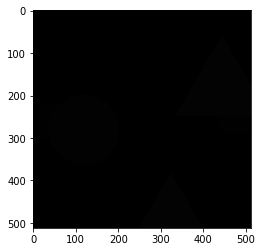

In [13]:
plt.imshow(a)

In [11]:
a.dtype

dtype('uint8')

In [13]:
list((200, 300)).pop(1)

300

In [5]:
a = dataset_train.load_image(1)

In [7]:
a.shape

(512, 512, 3)

In [15]:
a.size

(512, 512)

In [17]:
a = a.resize((256, 256))

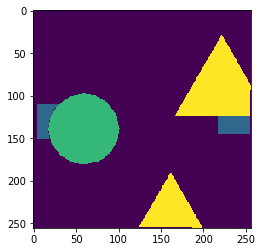

In [20]:
plt.imshow(np.asarray(a))

In [21]:
b = (1 ,2)

In [22]:
b

(1, 2)

In [23]:
tuple(b)

(1, 2)

In [24]:
pwd

'/home/keras/explorer/semantic-segmentation/notebooks'

In [25]:
ROOT_DATA_DIR

'/home/keras/data'

In [28]:
p = Image.open(ROOT_DATA_DIR + '/test/2007_000033.png')

In [33]:
q = np.asarray(p)

In [34]:
q.shape

(366, 500)

In [35]:
p.size

(500, 366)

In [21]:
a = dataset_train.load_image(1)

In [15]:
a.shape

(512, 512, 3)

In [16]:
a.resize((256, 256))

In [20]:
a.shape

(256, 256)

In [17]:
type(a)

numpy.ndarray

In [26]:
b, _, _, _, _ = semantic.utils.resize_image(a, max_dim=256)

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


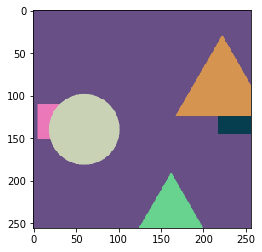

In [28]:
plt.imshow(b)

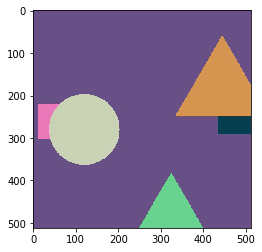

In [29]:
plt.imshow(a)

In [32]:
max((18, 5, 6))

18

In [50]:
import semantic.utils as sutils
import warnings
max_dim = max((256, 256))

In [42]:
x = dataset_train.load_image(1)

In [76]:
x, _, scale, padding, crop = sutils.resize_image(x, max_dim=max_dim)

In [84]:
y = dataset_train.load_class_mask(1)

In [85]:
import warnings
import scipy

def resize_mask(mask, scale, padding, crop=None):
    """Resizes a mask using the given scale and padding.
    Typically, you get the scale and padding from resize_image() to
    ensure both, the image and the mask, are resized consistently.

    scale: mask scaling factor
    padding: Padding to add to the mask in the form
            [(top, bottom), (left, right), (0, 0)]
    """
    # Suppress warning from scipy 0.13.0, the output shape of zoom() is
    # calculated with round() instead of int()

    mask = scipy.ndimage.zoom(mask, zoom=[scale, scale], order=0)
    #if crop is not None:
    #    y, x, h, w = crop
        #mask = mask[y:y + h, x:x + w]
    #else:
    mask = np.pad(mask, padding[:2], mode='constant', constant_values=0)
    return mask


In [86]:
y = resize_mask(y, scale, padding, crop)

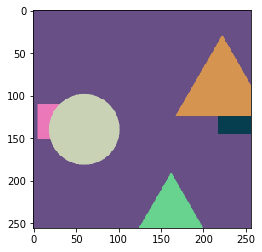

In [87]:
plt.imshow(x)

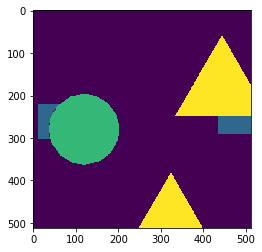

In [88]:
plt.imshow(y)

In [79]:
padding[:2]

[(0, 0), (0, 0)]